# Çok Katmanlı Algılayıcı (MLP)

## Hazırlık

In [1]:
# "hiper" parametreler:
n_blok = 3 # bir sonraki harfi tahmin ederken kaç harf öncesine bakacağız
n_katman = 100 # gizli katman boyutu
n_embed = 2 # bunu 2 yapmamızın özel bir sebebi var!
n_girdi = n_blok * n_embed
n_batch = 40 # her seferinde kaç örnek işleyeceğiz

In [2]:
# gerekli kütüphaneler
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

# bunlar bize hep lazım
alfabe = list('.abcçdefgğhıijklmnoöprsştuüvyz')
harf2idx = { harf:idx for idx, harf in enumerate(alfabe) }
idx2harf = { idx:harf for harf, idx in harf2idx.items() }

# bize lazım olan işlem: bir string alıp sonuna nokta ekle, başına bu sefer eklemiyoruz: veri yapımız blok adedi kadar "başlangıç noktası" ekleyecek
def isle(x):
    return list(x) + ['.']

# artık bigram ile işimiz yok. bize x y lazım ve buradaki x blok uzunluğunda harf dizisi, y ise bir sonraki harf
def xyOlustur(isimler):
  X, Y = [], []
  for isim in isimler:
    baglam = [0] * n_blok
    for idx in map(lambda harf: harf2idx[harf], isim):
      X.append(baglam)
      Y.append(idx)
      baglam = baglam[1:] + [idx]
  X, Y = torch.tensor(X), torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# isimleri okurken işleyelim
isimler = list(map(lambda isim: isle(isim), open("./isimler.txt", "r").read().splitlines()))

# adetlere devam:
n_alfabe = len(alfabe)
n_isim = len(isimler)
n_isim, isimler[0]

(29996, ['a', 'b', 'a', 'c', 'a', '.'])

## Girizgah

Bu safhada daha eskilerden bir [makaleyi](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) takip edeceğiz. Literatürdeki diğer çalışmalar gibi bu makalede harf seviyesinde değil kelime seviyesinde bir dil modeli üzerine fakat kavramsal olarak aynı sonucun peşindeyiz. Kabaca yol haritamız şöyle:
- Önceki çalışmamızı geliştiriyoruz: biraz daha nörona benzer yapıları üreteceğiz: ağırlık, aktivasyon ve önyargı olacak yani.
- Modeli "düzgün" bir şekilde başlatacağız.
- Girdileri doğrudan bu gizli nöron katmanına göndermeden arada bir `embedding` yapısı kullanacağız: kısaca harflerin bir vektör uzayında birbirine olan yakınlıklarını kullanma fikri diyebilirim ve çok yetersiz bir açıklama oldu diye ekleyerek [buraya](https://en.wikipedia.org/wiki/Word_embedding) yönlendirebilirim. Detayından ve modele ne katacağından ziyade bu süreçte uygulama yaparken bize ne katacağı önemli burada.
- Tekerleği icat ettiğimiz yerlere bir daha dönüp "bakın burada katlanmışı var!" nidalarıyla yapan kütüphanelere methiyeler düzeceğiz.
- İdeal bir `LR` değerini nasıl bulabiliriz buna bakacağız.

`n_` ön eki ile adetlerden bahsediyoruz.

Başlamadan önce veri yapımızı görelim:

In [3]:
isim = 'abacılar.'
print(f'\'{isim}\':')
baglam= ['.'] * n_blok
for harf in isim:
    x = ''.join(baglam)
    print(f'X: {x} -> Y: {harf}')
    baglam = baglam[1:] + [harf]

'abacılar.':
X: ... -> Y: a
X: ..a -> Y: b
X: .ab -> Y: a
X: aba -> Y: c
X: bac -> Y: ı
X: acı -> Y: l
X: cıl -> Y: a
X: ıla -> Y: r
X: lar -> Y: .


## Örnek NN Oluşturalım

In [4]:
ornekX, ornekY = xyOlustur(isimler[:5])
n_ornek = len(ornekX)
n_ornek

torch.Size([38, 3]) torch.Size([38])


38

2 boyutlu bir `embedding` matris oluşturacağız demiştik; buna uygun bir yapı kurmak için faydalanacağımız matris çarpımı işleminin kurallarına riayet etmemiz gerek, ilk 5 isim için bir örnek yapalım:

- her bir harf için 2 boyutlu bir (embed) matris yaptık: 30x2
- ilk 5 isim için elimizde 38 X Y var, biz X değerlerini girdi olarak kullanacağız, dolayısıyla ilgilendiğimiz matris: 38x3
- bu ikisini çarptığımızda 38x3x2 boyutunda bir matris elde edeceğiz,
- bunu bir sonraki işleme tabi girdi olarak kullanabilmek üzere 38x6 boyutuna getirmeliyiz: bunun için `torch` kütüphanesinde birçok yöntem mevcut; en efektifi ise `.view()`. ilk boyutu koruması için -1, diğer iki boyutu birleştirmesi için 6 parametresi veriyoruz.
- gizli katmanda 100 nöron istediğimiz için ağırlık=6x100 önyargı=1x100 olacak
- bu 100 nörondan çıktı üretirken 30 harften birine ihtiyacımız olduğu için son katman 100x30 ve 1x30 şeklinde olacak.

In [5]:
g = torch.Generator().manual_seed(5) # tekrarlanabilirlik için

# embedding matrisi, isim makaleden geliyor
ornekC = torch.randn((n_alfabe, n_embed), generator = g)

# gizli katman için ağırlıklar ve bias
ornekW1 = torch.randn((n_girdi, n_katman), generator = g)
ornekB1 = torch.randn(n_katman, generator = g)

# çıktı katmanı için ağırlıklar ve bias
ornekW2 = torch.randn((n_katman, n_alfabe), generator = g)
ornekB2 = torch.randn(n_alfabe, generator = g)


embed = ornekC[ornekX]
girdi = embed.view(-1, n_girdi) # bunu yapmanın binbir türlü yolu var ama en efektifi bu; meraklısına: http://blog.ezyang.com/2019/05/pytorch-internals/
gizli = torch.tanh(girdi @ ornekW1 + ornekB1)
logits = gizli @ ornekW2 + ornekB2

def shapeStr(x):
   return f'{x.shape[0]}x{x.shape[1]}'

print(f'embed: {embed.shape}')
print(f'{shapeStr(girdi)} @ {shapeStr(ornekW1)} = {shapeStr(gizli)}')
print(f'{shapeStr(gizli)} @ {shapeStr(ornekW2)} = {shapeStr(logits)}')

embed: torch.Size([38, 3, 2])
38x6 @ 6x100 = 38x100
38x100 @ 100x30 = 38x30


Örnek üzerinde son bir hususa bakıp eğitim işine ayırdığımız büyük kümeler üzerinde devam edeceğiz. Kusur için bulduğumuz ölçüyü ilk defa biz keşfetmedik: sadece mantığını anlamaya çalışıyoruz ve sanırım yeterince anladık. Bundan sonrası için "arkadaşlar bunun daha iyisini yapmışlar" nidalarıyla `torch` kütüphanesindeki `cross_entropy` fonksiyonunu kullanacağız. Aşağıda gördüğünüz gibi büyük oranda bizim hesapladığımız ile aynı; neden çok ufak bir fark olduğunu dileyen araştırabilir.

In [6]:
ornekP = torch.softmax(logits, dim = 1) # bunu da benzer şekilde el yordamıyla bulduktan sonra terfi etmiştik :)
hesaplanan = -ornekP[torch.arange(n_ornek), ornekY].log().mean()
c_entropy = F.cross_entropy(logits, ornekY) # bu ise yeni, bundan sonra kullanacağız!!

print('hesapladığımız:', hesaplanan.item())
print('cross_entropy :', c_entropy.item())
print('fark          :', (hesaplanan - c_entropy).item())

hesapladığımız: 10.326420783996582
cross_entropy : 10.32641887664795
fark          : 1.9073486328125e-06


Örnek bile olsa şu an modelin 10 gibi yüksek bir loss ile başlaması normal mi ya da başlangıçta belli bir loss değeri ummalı mıyız? Tabii ki evet: bir bilgimiz yokken 1/30 ihtimalle başlamalıyız; bu da bize başlangıç loss değerinin (-log(1/30) ~=) 3.4 civarı olması gerektiğini söylüyor.

## MLP Eğitelim!

### Eğitim/Validasyon

Önceki 2 uygulamamızda verinin tümünü kullandık fakat artık daha aklı başında işler yapmanın vakti geldi: yeterince çok parametresi olan bir modele eldeki tüm veriyi teslim edersek bunu hafızasına alıp sonra ense yapacaktır. Bunun önüne geçmenin en kolay yollarından biri tüm veri değil sadece bunun belli bir kısmı üzerinde eğitim yapmak. Kullanmayacağımız detaylara şimdilik girmiyoruz: %80 üzerinde eğitim yapıp tümü üzerindeki kazanımımıza bakacağız.

Bu dağılımı yapmadan önce veriyi bir karıştırmak da fena olmaz deyip işe koyulalım:

In [7]:
tumX, tumY = xyOlustur(isimler)

random.seed(5)
trnX, trnY = xyOlustur(random.sample(isimler, k = int(0.8 * n_isim)))

torch.Size([282166, 3]) torch.Size([282166])
torch.Size([225789, 3]) torch.Size([225789])


### Parametreler

[Bu makalede](https://arxiv.org/abs/1502.01852) arkadaşlar konuyu o kadar detaylı işlemiş ki adını fonksiyonlara vermişler: `torch` kütüphanesi makaleyi uygulamak üzere `kaiming_uniform_` isimli bir fonksiyon barındırıyor. Buna uygun olarak genel modelimizi örnekten farklı şekilde başlatacağız:

- `W1` tamamen makalede anlatıldığı gibi başlatılıyor,
- `B1` ve `W2` büyük sayıların oluşmaması için törpüleniyor,
- `B2` başlangıçta çıktı için önyargı istemediğimizden sıfırlanıyor.

In [8]:
g = torch.Generator().manual_seed(5)

C = torch.randn((n_alfabe, n_embed), generator = g)

W1 = torch.randn((n_girdi, n_katman), generator = g) * (5/3) / (n_girdi ** 0.5) 
B1 = torch.randn(n_katman, generator = g) * 0.02

W2 = torch.randn((n_katman, n_alfabe), generator = g) * 0.01
B2 = torch.zeros(n_alfabe)

tumParametreler = [C, W1, B1, W2, B2]
n_parametre = sum(p.nelement() for p in tumParametreler)

for p in tumParametreler:
  p.requires_grad = True

n_parametre

3790

Aynı problemi çözmek üzere geliştirilen "[Batch Normalization](https://arxiv.org/abs/1502.03167)" gibi yöntemler bu çalışmanın seviyesinin ötesinde; bir sonraki safhada bunu kullanacağız fakat detaylarına girmeyeceğiz.

### Temel Eğitim Yordamları

`fwd` ve `bwd` isimli 2 fonksiyon oluşturup birinde gelen veri ile loss hesaplayalım, diğerinde gelen loss ve lr ile modeli güncelleyelim. `ffwd` ise sadece loss hesaplamak için var; `@torch.no_grad()` ile bu fonksiyonda yapılan işlemler için kütüphaneye `grad` hesaplamamasını söylüyoruz.

In [9]:
def fwd(X, Y):
  girdi = C[X].view(-1, n_girdi)
  cikti = torch.tanh(girdi @ W1 + B1) @ W2 + B2
  return F.cross_entropy(cikti, Y)

def bwd(loss, lr):
  loss.backward()
  for p in tumParametreler:
    p.data += -lr * p.grad
    p.grad = None
  return loss

@torch.no_grad()
def ffwd(X, Y):
  return fwd(X, Y)

print('Başlangıç için yapılan düzenleme işe yaradı:')
print('beklenen:', -torch.tensor(1.0/n_alfabe).log().item())
print('oluşan  :', ffwd(tumX, tumY).item())


Başlangıç için yapılan düzenleme işe yaradı:
beklenen: 3.4011974334716797
oluşan  : 3.392152786254883


Eğitirken öğrenelim:

- veriyi kümelere ayırmıştık, eğitim kümesinde bulduğumuz loss değeri ile `bwd` yapalım ama nihai ölçümümüzü tüm veri üzerinde hesapladığımız loss ile yapalım
- veriyi bölmüş olsak da her seferinde tüm eğitim kümesi üzerinden geçmeyelim. Bu kümeden `n_mini` kadar örnek alıp bunları dikkate alalım. Hızımız artarken konvansiyondan bir uygulama daha görmüş oluruz.
- lr konusuna eğilelim: mesela _a_ ile _b_ arasındaki değerler için loss değerini ne kadar azaltabiliyoruz bunu görselleştirmeye çalışalım. Buradan bir şey öğrenebilirsek bunu kullanırız. 

3.597090482711792

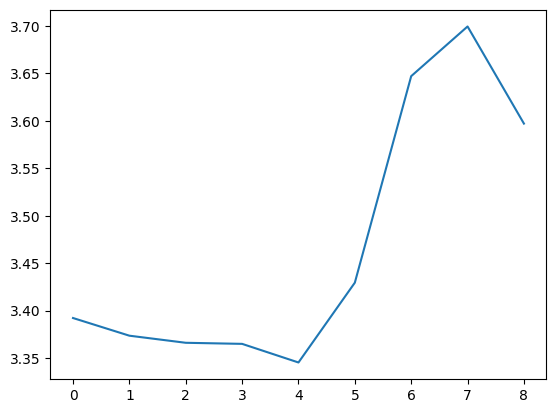

In [10]:
n_test, pltLoss = 9, []

for i in range(n_test):
  g = torch.Generator().manual_seed(i)
  batch = torch.randint(0, trnX.shape[0], (n_batch,), generator = g)
  bwd(fwd(trnX[batch], trnY[batch]), i/n_test)
  pltLoss.append(ffwd(tumX, tumY).item())


plt.plot(range(n_test), pltLoss)
ffwd(tumX, tumY).item()

In [12]:
n_epoch = 25000

for i in range(n_epoch):  
  g = torch.Generator().manual_seed(i)
  batch = torch.randint(0, trnX.shape[0], (n_batch,), generator = g)
  lr = 0.4 if i < 3000 else 0.3 if i < 5000 else 0.2 if i < 12000 else 0.1 if i < 21000 else 0.01
  bwd(fwd(trnX[batch], trnY[batch]), lr)
  if i % 1000 == 0:
    print(f'{ffwd(tumX, tumY).item():.4f} ({lr:.2f})')

3.3932 (0.40)
2.4884 (0.40)
2.4382 (0.40)
2.4364 (0.30)
2.3523 (0.30)
2.3473 (0.20)
2.2945 (0.20)
2.2897 (0.20)
2.2696 (0.20)
2.2735 (0.20)
2.2724 (0.20)
2.2606 (0.20)
2.2460 (0.10)
2.2102 (0.10)
2.2262 (0.10)
2.2023 (0.10)
2.2072 (0.10)
2.1964 (0.10)
2.1921 (0.10)
2.1950 (0.10)
2.1864 (0.10)
2.1892 (0.01)
2.1550 (0.01)
2.1532 (0.01)
2.1515 (0.01)


### Neden 2 boyutlu bir `embed` seçmiştik?

Aslında tamamen pratik nedenlerle: bu (sahte) "katman" eğitim esnasında modele harflerin mesafelerini öğrenme fırsatı veriyor. Bunu 2 boyutlu olarak görselleştirdiğimiz zaman biz de modelin ne öğrendiğini görebiliriz:

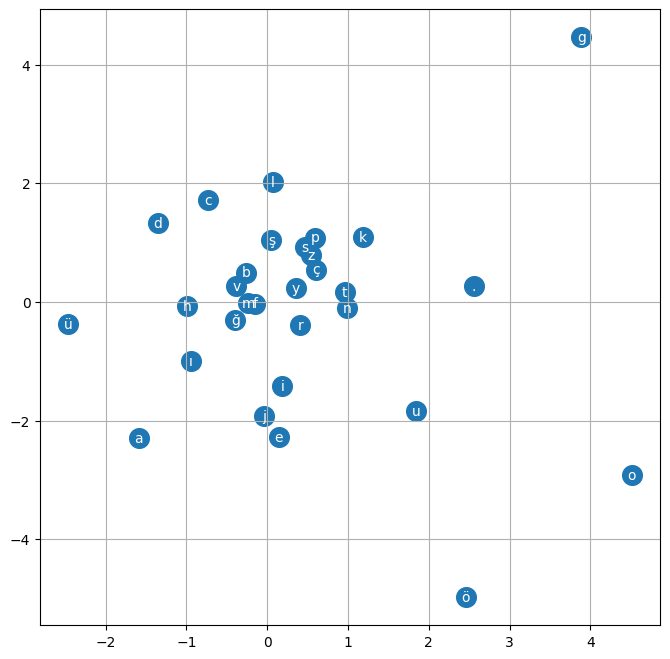

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), idx2harf[i], ha="center", va="center", color='white')
plt.grid('minor')

## Sonuç

In [14]:
g = torch.Generator().manual_seed(5)

for _ in range(25):
    ornek, baglam = [0], [0] * n_blok
    while True:
      girdi = C[torch.tensor([baglam])].view(1, -1)
      logits = torch.tanh(girdi @ W1 + B1) @ W2 + B2
      P = F.softmax(logits, dim=1)
      idx = torch.multinomial(P, num_samples = 1, generator = g).item()
      baglam = baglam[1:] + [idx]
      ornek.append(idx)
      if idx == 0:
        break
    print(''.join(idx2harf[i] for i in ornek))

.karar.
.çomular.
.karefentep.
.megübelit.
.çuem.
.güzlük.
.tepelar.
.deme.
.gücek.
.vehiddiye.
.çacınakkumekli.
.ıcıçıcatoğlu.
.aşcık.
.tincey.
.püneyikli.
.fısükü.
.akçınçabemiroğla.
.otu.
.atcı.
.gesin.
.bukçunoğunyırı.
.ambeleni.
.tofan.
.murd.
.yaşlı.
